In [14]:
import os
import gc
import io
import pickle
import datetime
#import psutil
import numpy as np
import pandas as pd
import torch
from torch import nn
from typing import Tuple, Dict
from google.cloud import storage
from mamba_ssm import Mamba  # your Mamba
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from torch.utils.data import DataLoader
from pytorch_forecasting.utils import move_to_device
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.strategies import DDPStrategy

# GCS constants
_BUCKET_NAME = "cgmproject2025"
_BASE_PREFIX = "models/predictions"
_gcs_client = storage.Client()

In [15]:
class ResidualMambaBlock(nn.Module):
    """Norm -> Mamba -> Dropout -> Residual."""
    def __init__(self, d_model: int, dropout: float = 0.1, checkpoint: bool = False):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(d_model=d_model)
        self.drop = nn.Dropout(dropout)
        self.checkpoint = checkpoint
    def _forward_inner(self, x: torch.Tensor) -> torch.Tensor:
        y = self.mamba(self.norm(x))
        return x + self.drop(y)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.checkpoint and self.training:
            return torch.utils.checkpoint.checkpoint(self._forward_inner, x, use_reentrant=False)
        return self._forward_inner(x)

class StackedMamba(nn.Module):
    """Stack multiple residual Mamba blocks."""
    def __init__(self, d_model: int, depth: int = 4, dropout: float = 0.1, checkpoint: bool = False):
        super().__init__()
        self.blocks = nn.ModuleList([
            ResidualMambaBlock(d_model, dropout, checkpoint) for _ in range(depth)
        ])
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for blk in self.blocks:
            x = blk(x)
        return x

class DummyMambaAttn(nn.Module):
    """Replace MultiHeadAttention with a lightweight Mamba mixer on q only."""
    def __init__(self, d_model: int, n_head: int = 1, depth: int = 1, dropout: float = 0.0):
        super().__init__()
        self.n_head = n_head
        self.mixer = StackedMamba(d_model=d_model, depth=depth, dropout=dropout)
    def forward(self, q, k=None, v=None, mask=None):
        out = self.mixer(q)
        B, L_q, _ = q.shape
        L_k = k.size(1) if k is not None else L_q
        attn = q.new_zeros(B, self.n_head, L_q, L_k)
        return out, attn


In [16]:
class MambaTFT(TemporalFusionTransformer):
    """Temporal Fusion Transformer with LSTM & MHA replaced by Mamba blocks."""
    def __init__(self, *args, mamba_depth: int = 4, mamba_dropout: float = 0.1, mamba_checkpoint: bool = False, **kwargs):
        super().__init__(*args, **kwargs)
        del self.lstm_encoder
        del self.lstm_decoder
        del self.multihead_attn
        del self.static_context_initial_cell_lstm
        del self.static_context_initial_hidden_lstm
        d_model = self.hparams.hidden_size
        self.lstm_encoder = StackedMamba(
            d_model=d_model,
            depth=mamba_depth,
            dropout=mamba_dropout,
            checkpoint=mamba_checkpoint,
        )
        self.lstm_decoder = nn.Identity()
        self.multihead_attn = DummyMambaAttn(
            d_model=d_model,
            n_head=self.hparams.attention_head_size,
            depth=1,
            dropout=mamba_dropout,
        )
    def forward(self, x: Dict[str, torch.Tensor]):
        encoder_lengths = x["encoder_lengths"]
        decoder_lengths = x["decoder_lengths"]
        total_lengths = encoder_lengths + decoder_lengths
        x_cat = torch.cat([x["encoder_cat"], x["decoder_cat"]], dim=1)
        x_cont = torch.cat([x["encoder_cont"], x["decoder_cont"]], dim=1)
        timesteps = x_cont.size(1)
        max_encoder_length = int(encoder_lengths.max())
        input_vectors = self.input_embeddings(x_cat)
        input_vectors.update({
            name: x_cont[..., idx].unsqueeze(-1)
            for idx, name in enumerate(self.hparams.x_reals)
            if name in self.reals
        })
        if len(self.static_variables) > 0:
            static_embedding_src = {name: input_vectors[name][:, 0] for name in self.static_variables}
            static_embedding, static_variable_selection = self.static_variable_selection(static_embedding_src)
        else:
            static_embedding = torch.zeros((x_cont.size(0), self.hparams.hidden_size), dtype=self.dtype, device=self.device)
            static_variable_selection = torch.zeros((x_cont.size(0), 0), dtype=self.dtype, device=self.device)
        static_context_varsel = self.expand_static_context(self.static_context_variable_selection(static_embedding), timesteps)
        embeddings_varying_encoder = {n: input_vectors[n][:, :max_encoder_length] for n in self.encoder_variables}
        embeddings_varying_encoder, encoder_sparse_weights = self.encoder_variable_selection(
            embeddings_varying_encoder, static_context_varsel[:, :max_encoder_length]
        )
        embeddings_varying_decoder = {n: input_vectors[n][:, max_encoder_length:] for n in self.decoder_variables}
        embeddings_varying_decoder, decoder_sparse_weights = self.decoder_variable_selection(
            embeddings_varying_decoder, static_context_varsel[:, max_encoder_length:]
        )
        embeddings_full = torch.cat([embeddings_varying_encoder, embeddings_varying_decoder], dim=1)
        full_seq = self.lstm_encoder(embeddings_full)
        encoder_output = full_seq[:, :max_encoder_length]
        decoder_output = full_seq[:, max_encoder_length:]
        lstm_output_encoder = self.post_lstm_gate_encoder(encoder_output)
        lstm_output_encoder = self.post_lstm_add_norm_encoder(lstm_output_encoder, embeddings_varying_encoder)
        lstm_output_decoder = self.post_lstm_gate_decoder(decoder_output)
        lstm_output_decoder = self.post_lstm_add_norm_decoder(lstm_output_decoder, embeddings_varying_decoder)
        lstm_output = torch.cat([lstm_output_encoder, lstm_output_decoder], dim=1)
        static_context_enrich = self.static_context_enrichment(static_embedding)
        attn_input = self.static_enrichment(lstm_output, self.expand_static_context(static_context_enrich, timesteps))
        attn_output, attn_output_weights = self.multihead_attn(
            q=attn_input[:, max_encoder_length:],
            k=attn_input,
            v=attn_input,
            mask=self.get_attention_mask(encoder_lengths=encoder_lengths, decoder_lengths=decoder_lengths),
        )
        attn_output = self.post_attn_gate_norm(attn_output, attn_input[:, max_encoder_length:])
        output = self.pos_wise_ff(attn_output)
        output = self.pre_output_gate_norm(output, lstm_output[:, max_encoder_length:])
        if self.n_targets > 1:
            output = [layer(output) for layer in self.output_layer]
        else:
            output = self.output_layer(output)
        return self.to_network_output(
            prediction=self.transform_output(output, target_scale=x["target_scale"]),
            encoder_attention=attn_output_weights[..., :max_encoder_length],
            decoder_attention=attn_output_weights[..., max_encoder_length:],
            static_variables=static_variable_selection,
            encoder_variables=encoder_sparse_weights,
            decoder_variables=decoder_sparse_weights,
            decoder_lengths=decoder_lengths,
            encoder_lengths=encoder_lengths,
        )


In [17]:
def load_tft_from_gcs(
    training_dataset,
    model_name: str = "default_model",
    map_location=None,
    bucket_name: str = _BUCKET_NAME,
    prefix: str = _BASE_PREFIX,
) -> MambaTFT:
    """Fetch model_kwargs.pkl and model.pth from GCS, rebuild the TFT, load weights, and return it."""
    if map_location is None:
        map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bucket = _gcs_client.bucket(bucket_name)
    model_prefix = f"{prefix}/{model_name}"
    blob = bucket.blob(f"{model_prefix}/model_kwargs.pkl")
    hparams_bytes = blob.download_as_bytes()
    model_kwargs = pickle.loads(hparams_bytes)
    tft = MambaTFT.from_dataset(training_dataset, **model_kwargs)
    blob = bucket.blob(f"{model_prefix}/model.pth")
    state_bytes = blob.download_as_bytes()
    buf = io.BytesIO(state_bytes)
    state_dict = torch.load(buf, map_location=map_location)
    tft.load_state_dict(state_dict)
    buf.close()
    print(f"✅ Loaded TFT from gs://{bucket_name}/{model_prefix}/")
    return tft

In [18]:
def create_tft_dataloaders(train_df, horizon=12, context_length=72, batchsize=32):
    """Create PyTorch Forecasting dataloaders for TFT."""
    log_memory("🚀 Start of Dataloader Creation")
    static_categoricals = ["participant_id", "clinical_site", "study_group"]
    static_reals = ["age"]
    time_varying_known_categoricals = ["sleep_stage"]
    time_varying_known_reals = [
        "ds", "minute_of_day", "tod_sin", "tod_cos", "activity_steps", "calories_value",
        "heartrate", "oxygen_saturation", "respiration_rate", "stress_level", 'predmeal_flag',
    ]
    time_varying_unknown_reals = [
        "cgm_glucose", "cgm_lag_1", "cgm_lag_3", "cgm_lag_6", "cgm_diff_lag_1", "cgm_diff_lag_3",
        "cgm_diff_lag_6", "cgm_lagdiff_1_3", "cgm_lagdiff_3_6", "cgm_rolling_mean", "cgm_rolling_std",
    ]
    cut_off_date = train_df["ds"].max() - horizon
    training = TimeSeriesDataSet(
        train_df[train_df["ds"] < cut_off_date],
        time_idx="ds",
        target="cgm_glucose",
        group_ids=["participant_id"],
        max_encoder_length=context_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_categoricals=time_varying_known_categoricals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=["participant_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    validation = training.from_dataset(training, train_df, predict=True, stop_randomization=True)
    train_dataloader = training.to_dataloader(
        train=True, batch_size=batchsize, persistent_workers=False, num_workers=1, pin_memory=False
    )
    val_dataloader = validation.to_dataloader(
        train=False, batch_size=batchsize, num_workers=0, persistent_workers=False, pin_memory=False
    )
    return training, val_dataloader, train_dataloader, validation

In [19]:
def log_memory(message=""):
    """Log CPU and GPU memory usage."""
    pid = os.getpid()
    #process = psutil.Process(pid)
    #mem_cpu = process.memory_info().rss / 1e9  # in GB
    if torch.cuda.is_available():
        mem_gpu_allocated = torch.cuda.memory_allocated() / 1e9
        mem_gpu_reserved = torch.cuda.memory_reserved() / 1e9
    else:
        mem_gpu_allocated = mem_gpu_reserved = 0.0
    print(f"[{datetime.datetime.now()}] {message}")
    #print(f"🧠 CPU Mem used: {mem_cpu:.2f} GB")
    print(f"🎮 GPU Mem allocated: {mem_gpu_allocated:.2f} GB | reserved: {mem_gpu_reserved:.2f} GB")


In [20]:
# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_timeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))

In [21]:
# Rebuild the training dataset (same context_length, horizon, etc.)
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=288, batchsize=32)

[2025-08-03 13:26:10.489384] 🚀 Start of Dataloader Creation
🎮 GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


In [22]:
tft = load_tft_from_gcs(model_name="MambaTFT_12horizon_288context", training_dataset=training)
tft.eval()  # Put model in evaluation mode

/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


✅ Loaded TFT from gs://cgmproject2025/models/predictions/MambaTFT_12horizon_288context/


MambaTFT(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 288, 'min_encoder_length': 288, 'min_prediction_idx': np.int64(14), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'max_eigenvalues'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_ro

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x800 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

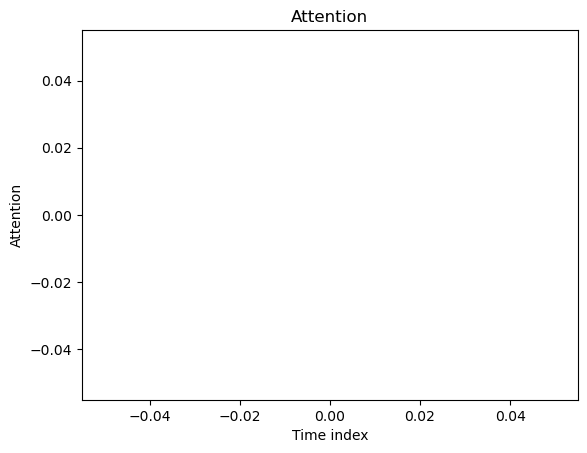

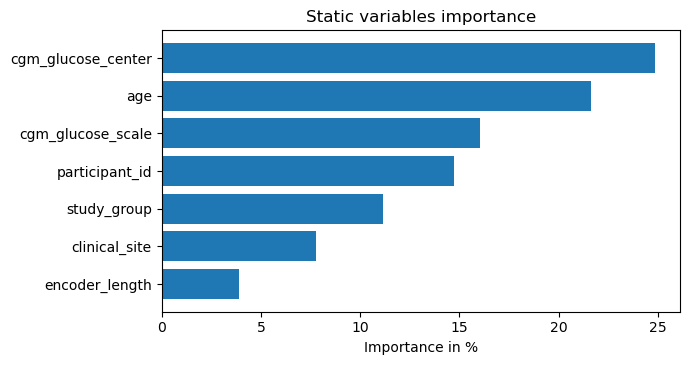

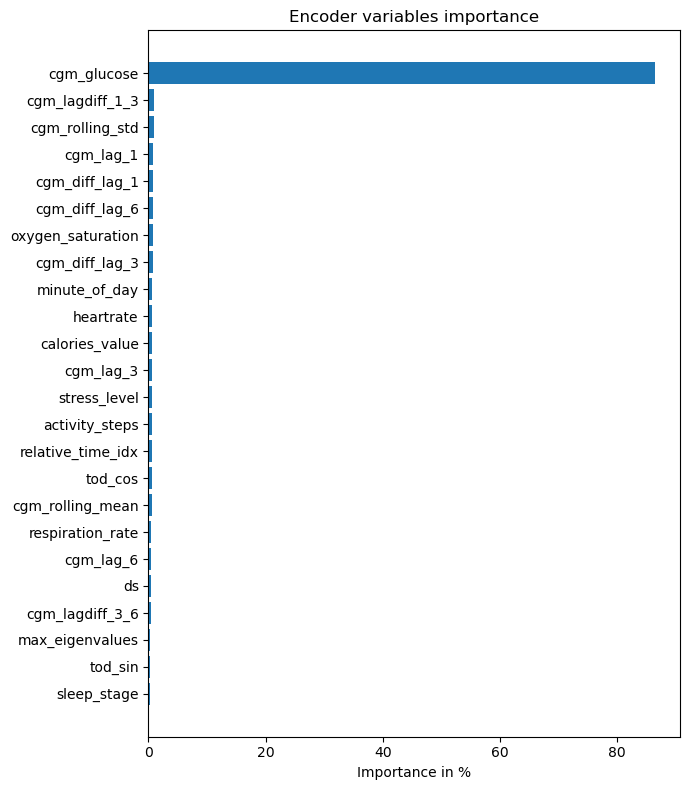

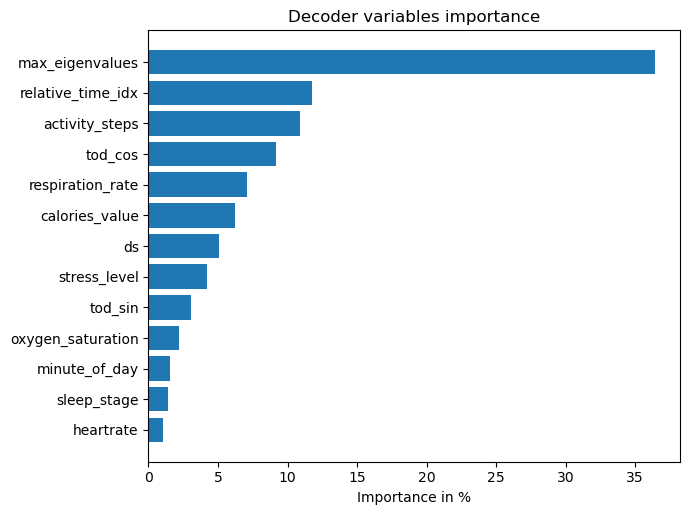

In [23]:
# --- Prédiction ---
# Assure-toi que val_dataloader est bien structuré
y_hat_raw = tft.predict(val_dataloader, mode="raw")
# --- Visualisation des interprétations ---
interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
tft.plot_interpretation(interpretation)